# Google Tutorial - Convolutional Variational Autoencoder

이 노트북은 MNIST에서 VAE (Variational Autoencoder)를 학습시키는 방법을 보여줍니다. VAE는 높은 차원의 입력 데이터를 가져와 더 작은 표현으로 압축하는 모델인 오토인코더에 대한 확률론적 해석입니다. 입력을 잠재 벡터에 매핑하는 기존 오토인코더와 달리 VAE는 입력 데이터를 가우시안 평균 및 분산과 같은 확률 분포의 매개 변수에 매핑합니다. 이 접근 방식은 이미지 생성에 유용한 연속적이고 구조화 된 잠재 공간을 생성합니다.  

<img src="autoencoder_3.png" width=600>

![evolution of output during training](https://tensorflow.org/images/autoencoders/cvae.gif)

- Variational Autoencoder 를 훈련시켜 손글씨 digit 이미지 생성

In [ ]:
# to generate gifs
#!pip install imageio  

In [2]:
import tensorflow as tf

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
import tensorflow.keras.layers as tkl
import tensorflow_probability as tfp

from IPython import display

## Load the MNIST dataset
각 MNIST 이미지는 원래 784 개의 정수로 구성된 벡터이며, 각 정수는 0-255 사이이며 픽셀의 강도를 나타냅니다. 모델에서 Bernoulli 분포로 각 픽셀을 모델링하고 데이터 세트를 정적으로 이진화합니다.

In [3]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

print(train_images.shape)
print(test_images.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


#### Binarization (이항변수화)
- 연속형 변수를 특정 기준값 이하이면 '0', 초과이면 '1'의 두 개의 값만을 가지는 변수로 변환 
- train_images 와 test_images 를 0 과 1 의 두가지 값으로 변경

In [4]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

In [5]:
train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [24]:
train_size = 60000
batch_size = 32
test_size = 10000

## *tf.data* 를 이용하여 batche 생성 및 dataset shuffling

In [7]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                .shuffle(TRAIN_BUF).batch(BATCH_SIZE))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(TEST_BUF).batch(BATCH_SIZE))

print(train_dataset)
print(test_dataset)

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>
<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>


## * tf.keras.Sequential *을 사용하여 생성 및 추론 네트워크를 연결

VAE 예제에서는 생성 및 추론 네트워크에 두 개의 작은 ConvNet을 사용합니다. 이러한 신경망은 작기 때문에 코드를 단순화하기 위해`tf.keras.Sequential`을 사용합니다. 다음 설명에서 x 와 z 는 각각 관측 값과 잠재 변수를 나타냅니다.

### Inference Network (Encoder network) 
 
 
- 이것은 대략적인 사후 분포 q(𝑧|𝑥)를 정의하는데, 관측 값을 입력으로 받고 잠재 표현의 조건부 분포에 대한 매개 변수 세트를 출력합니다. 수치적 안정성을 위해 variance 를 직접 출력하는 대신 log-variance를 출력합니다. 

### Generative Network (Decoder network)

- 관측치 𝑝(𝑥|𝑧)의 조건부 분포를 정의합니다. 잠재 인코딩(latent encoding) sample z 을 입력으로 받아 관측치의 조건부 분포에 대한 매개변수(parameter)를 출력합니다. 가우시안 단위로 잠재 분포 사전확률 𝑝(𝑧)를 modeling 합니다.  


- 잠재변수 <i>z</i> 는 입력 데이터를 추상화한 잠재적 특징


### Reparameterization Trick
- 최적화(optimization) 중에, 먼저 단위 가우시안에서 샘플링 한 다음 표준 편차를 곱하고 평균을 더하여 𝑞 (𝑧 | 𝑥)에서 샘플링 할 수 있습니다.   
- 그러나 이 샘플링 작업은 역전파가 임의의 노드를 통해 흐를 수 없기 때문에 병목 현상을 만듭니다. 이를 해결하려면 매개 변수화 트릭을 사용하십시오.  
- 이 예에서는 디코더 매개 변수와 다른 매개 변수 $\epsilon$을 사용하여 다음과 같이 $z$를 근사화 합니다.

$$z = \mu + \sigma \odot \epsilon$$

여기서 $\mu$ 와 $\sigma$는 가우스 분포의 평균과 표준 편차를 각각 나타냅니다. 이 것들은 디코더 출력에서 파생될 수 있습니다. $\epsilon$은 $z$의 확률성을 유지하는 데 사용되는 임의의 노이즈로 생각할 수 있습니다. 표준 정규 분포에서 $\epsilon$을 생성합니다. 

- 잠재 변수 $z$는 이제 $\mu$, $\sigma$  및 $\epsilon$의 함수에 의해 생성되므로, 그래디언트가 샘플을 통해 추론 네트워크 매개 변수로 전달 될 수 있습니다. $\epsilon$을 통해 확률성을 유지합니다.

### Network architecture
추론 네트워크(encoder)로, 우리는 두 개의 컨볼루션 레이어와 한개의 Dense 레이어를 사용합니다. 생성네트워크(decoder)에서, 우리는 한개의 Dense 레이어와 3 개의 컨볼루션 전치 레이어 (convolution transpose layer - deconvolutional layer 로도 불림)를 사용하여 이 아키텍처를 미러링합니다. Mini-batch 사용으로 인한 추가 확률이 샘플링의 확률보다 불안정성을 악화시킬 수 있으므로 VAE 훈련시 배치 정규화를 사용하지 않는 것이 일반적입니다.

In [17]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.inference_net = tf.keras.Sequential(
            [
                tkl.InputLayer(input_shape=(28, 28, 1)),
                tkl.Conv2D(filters=32, kernel_size=3, 
                           strides=(2, 2), activation='relu'),
                tkl.Conv2D(filters=64, kernel_size=3, 
                            strides=(2, 2), activation='relu'),
                tkl.Flatten(),
                tkl.Dense(latent_dim + latent_dim),
            ]
        )
        
        self.generative_net = tf.keras.Sequential(
            [
                tkl.InputLayer(input_shape=(latent_dim,)),
                tkl.Dense(units=7*7*32, activation='relu'),
                tkl.Reshape(target_shape=(7, 7, 32)),
                tkl.Conv2DTranspose(filters=64, kernel_size=3, 
                                    strides=(2, 2), padding='same', 
                                    activation='relu'),
                tkl.Conv2DTranspose(filters=32, kernel_size=3, 
                                    strides=(2, 2), padding='same', 
                                    activation='relu'),
                tkl.Conv2DTranspose(filters=1, kernel_size=3, 
                                    strides=(1, 1), padding='same')
            ]           
        )
        
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):     
        mean, logvar = tf.split(self.inference_net(x), 
                                num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

## Define the loss function and the optimizer
VAE는 marginal log-likelihood 대한 evidence lower bound (ELBO)을 최대화하여 교육합니다.

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

실제로, 우리는이 예상에 대한 단일 샘플 Monte Carlo 추정값을 최적화합니다:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

참고 : KL 항을 분석적으로 계산할 수도 있지만 여기서는 단순성을 위해 Monte Carlo Estimator에 세 항을 모두 통합합니다.

In [18]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), 
        axis=raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## Training

* 데이터 세트를 반복하여 시작합니다
* 각 반복 동안 이미지를 인코더로 전달하여 대략적 사후분포 𝑞 (𝑧 | 𝑥)의 평균 및 로그 분산 매개 변수 세트를 얻습니다.
* 그런 다음 q (𝑧 | 𝑥)에서 샘플링하기 위해 reparameterization trick 을 적용합니다.
* 마지막으로, 우리는 생성 된 분포의 로짓을 얻기 위해 재 파라미터화 된 샘플을 디코더로 전달합니다 𝑝 (𝑥 | 𝑧)

참고 : 훈련 세트에 60k 데이터와 테스트 세트에 10k 데이터가있는 keras 가 로드 한 데이터 세트를 사용하기 때문에 테스트 세트의 결과 ELBO는 Larochelle의 MNIST의 동적 이진화를 사용하는 문헌에서보고 된 결과보다 약간 높습니다.

## Generate Images

* 훈련 후 이미지를 생성 할 차례입니다
* 우리는 단위 가우스 사전 분포 𝑝 (𝑧)에서 잠재 벡터 세트를 샘플링하여 시작합니다.
* 그런 다음 generator 는 latent sample 𝑧을 관측치의 로짓으로 변환하여 분포 𝑝 (𝑥|𝑧)를 제공합니다.
* 여기서 Bernoulli 분포의 확률을 플로팅합니다.

In [20]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so 
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])

model = CVAE(latent_dim)

print(random_vector_for_generation.shape)

(16, 2)


In [29]:
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [30]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

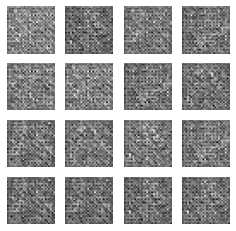

In [31]:
generate_and_save_images(model, 0, test_sample)

Epoch: 10, Test set ELBO: -156.60557556152344, time elapse for current epoch 4.8985915184021


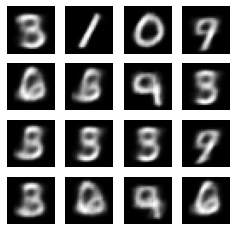

In [32]:
for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        train_step(model, train_x, optimizer)
    end_time = time.time()
    
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch {}'
            .format(epoch, elbo, end_time - start_time))
    generate_and_save_images(model, epoch, test_sample)

### Display a generated image from the last training epoch

In [33]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 287.5, 287.5, -0.5)

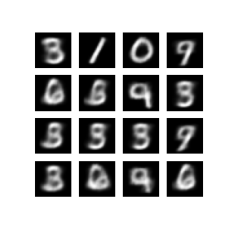

In [34]:
plt.imshow(display_image(epochs))
plt.axis('off')# Display images

### 잠재 공간에서 숫자의 2D 매니 폴드 표시

아래 코드를 실행하면 2D latent space에서 각 숫자가 다른 숫자로 변하는 다양한 숫자 클래스의 연속 분포가 표시됩니다. [TensorFlow Probability](https://www.tensorflow.org/probability)를 사용하여 잠재 공간에 대한 표준 정규 분포를 생성합니다.

In [35]:
def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

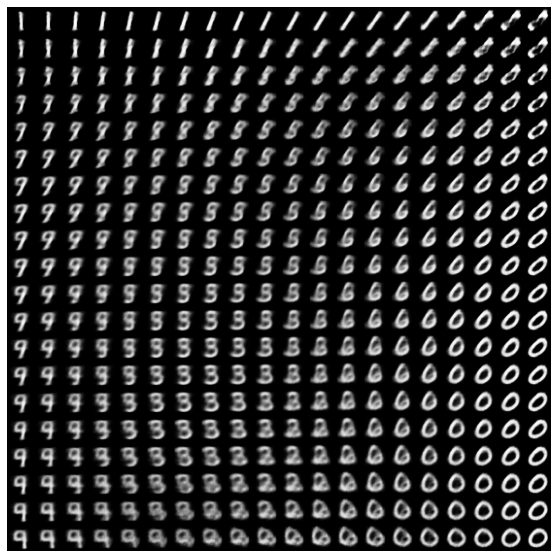

In [36]:
plot_latent_images(model, 20)

## 다음 단계

이 튜토리얼에서는 TensorFlow를 사용하여 convolutional variational autoencoder를 구현하는 방법을 보여주었습니다.

다음 단계로 네트워크 크기를 늘려 모델 출력을 개선 할 수 있습니다.
예를 들어 `Conv2D`및 `Conv2DTranspose` 레이어 각각에 대한 `filter` 매개 변수를 512로 설정할 수 있습니다.
최종 latent 2d image 플롯을 생성하려면 `latent_dim` 을 2로 유지해야합니다. 또한 네트워크 크기가 증가함에 따라 훈련 시간이 늘어납니다.

CIFAR-10과 같은 다른 데이터 세트를 사용하여 VAE를 구현해 볼 수도 있습니다.

VAE에 대한 자세한 내용은 [An Introduction to Variational Autoencoders](https://arxiv.org/abs/1906.02691)를 참조하십시오.